In [4]:

!pip install -q torch torchvision
!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git
!pip install -q transformers opencv-python pillow matplotlib


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:


import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import os

# Create checkpoints directory
os.makedirs("checkpoints", exist_ok=True)

# Download SAM 2 checkpoint
sam2_checkpoint = "checkpoints/sam2_hiera_large.pt"
if not os.path.exists(sam2_checkpoint):
    print("Downloading SAM 2 checkpoint (~900MB)...")
    !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -O checkpoints/sam2_hiera_large.pt
    print("SAM 2 downloaded!")
else:
    print("SAM 2 checkpoint already exists!")

SAM 2 downloaded!


In [3]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n{'='*70}")
print(f"Using device: {device}")
print(f"{'='*70}\n")


model_cfg = "sam2_hiera_l.yaml"
sam2_predictor = SAM2ImagePredictor(
    build_sam2(model_cfg, sam2_checkpoint, device=device)
)
print(" SAM 2 loaded successfully!\n")


print("Loading CLIPSeg")
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = clipseg_model.to(device)
print("CLIPSeg loaded successfully!\n")


def download_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(image)

def get_region_from_text(image, text_prompt, threshold=0.4):

    # Convert to PIL
    image_pil = Image.fromarray(image)

    # Process with CLIPSeg
    inputs = processor(
        text=[text_prompt],
        images=[image_pil],
        padding=True,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}


    with torch.no_grad():
        outputs = clipseg_model(**inputs)


    preds = outputs.logits
    heatmap = torch.sigmoid(preds[0]).cpu().numpy()


    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))


    binary_mask = (heatmap_resized > threshold).astype(np.uint8)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for contour in contours:
        if cv2.contourArea(contour) > 100:  # Filter small regions
            x, y, w, h = cv2.boundingRect(contour)
            boxes.append([x, y, x + w, y + h])

    return np.array(boxes), heatmap_resized



Using device: cuda



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


 SAM 2 loaded successfully!

Loading CLIPSeg


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

CLIPSeg loaded successfully!



In [8]:

def segment_with_sam2(image, boxes):

    if len(boxes) == 0:
        return np.array([]), np.array([])

    # Set image for SAM 2
    sam2_predictor.set_image(image)

    # Convert boxes to tensor
    input_boxes = torch.tensor(boxes, dtype=torch.float32, device=device)

    # Generate masks for all boxes at once
    masks, scores, _ = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    return masks, scores


def text_driven_segmentation(image, text_prompt, threshold=0.4):


    print(f"Prompt: '{text_prompt}'")
    print(f"Image shape: {image.shape}")
    print()

    # Step 1: Text to Region (CLIPSeg)
    print("Step 1: Converting text to regions using CLIPSeg...")
    boxes, heatmap = get_region_from_text(image, text_prompt, threshold)

    if len(boxes) == 0:
        print(f" No regions detected for '{text_prompt}'")
        print("  Suggestions:")
        print(f"  • Lower threshold (current: {threshold}, try: 0.3 or 0.2)")

        return None, None

    print(f"Found {len(boxes)} region(s)")
    for i, box in enumerate(boxes):
        print(f"  Region {i+1}: [{box[0]:.0f}, {box[1]:.0f}, {box[2]:.0f}, {box[3]:.0f}]")
    print()

    # Step 2: Region to Mask (SAM 2)
    print("Step 2: Generating precise masks using SAM 2...")
    masks, scores = segment_with_sam2(image, boxes)
    print(f"Generated {len(masks)} mask(s)")
    print(f"  Mask quality scores: {scores}")
    print()

    # Step 3: Visualize
    print("Step 3: Visualizing results...")
    visualize_results(image, masks, boxes, text_prompt, heatmap)

    print(" Segmentation complete!")


    return masks, boxes

In [9]:
def visualize_results(image, masks, boxes, text_prompt, heatmap=None):

    num_plots = 4 if heatmap is not None else 3
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 6))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title("1. Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # CLIPSeg heatmap (if provided)
    if heatmap is not None:
        axes[1].imshow(image)
        axes[1].imshow(heatmap, alpha=0.5, cmap='jet')
        axes[1].set_title(f"2. CLIPSeg Attention\n'{text_prompt}'", fontsize=14, fontweight='bold')
        axes[1].axis('off')
        box_ax = axes[2]
        mask_ax = axes[3]
    else:
        box_ax = axes[1]
        mask_ax = axes[2]

    # Bounding boxes
    img_with_boxes = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(img_with_boxes, f"Region {i+1}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    box_ax.imshow(img_with_boxes)
    box_ax.set_title(f"{2 if heatmap is None else 3}. Detected Regions", fontsize=14, fontweight='bold')
    box_ax.axis('off')

    # Final segmentation mask - FIXED VERSION
    img_with_mask = image.copy()

    if len(masks) > 0:
        # Combine all masks
        h, w = image.shape[:2]
        combined_mask = np.zeros((h, w), dtype=bool)

        for mask in masks:
            # Get mask and ensure correct shape
            m = mask[0] if len(mask.shape) == 3 else mask

            # Resize if dimensions don't match
            if m.shape != (h, w):
                m = cv2.resize(m.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)

            combined_mask = np.logical_or(combined_mask, m.astype(bool))

        # Create red overlay ONLY on masked pixels
        overlay = img_with_mask.copy()
        overlay[combined_mask] = [255, 0, 0]  # Pure red

        # Blend: 60% original + 40% red overlay
        img_with_mask = cv2.addWeighted(img_with_mask, 0.6, overlay, 0.4, 0)

    mask_ax.imshow(img_with_mask)
    mask_ax.set_title(f"{3 if heatmap is None else 4}. SAM 2 Segmentation", fontsize=14, fontweight='bold')
    mask_ax.axis('off')

    plt.tight_layout()
    plt.show()

EXAMPLE 1: Segment a dog from sample image
 Image loaded: (533, 800, 3)

Prompt: 'dog'
Image shape: (533, 800, 3)

Step 1: Converting text to regions using CLIPSeg...
Found 1 region(s)
  Region 1: [294, 84, 800, 533]

Step 2: Generating precise masks using SAM 2...
Generated 1 mask(s)
  Mask quality scores: [0.9799817]

Step 3: Visualizing results...


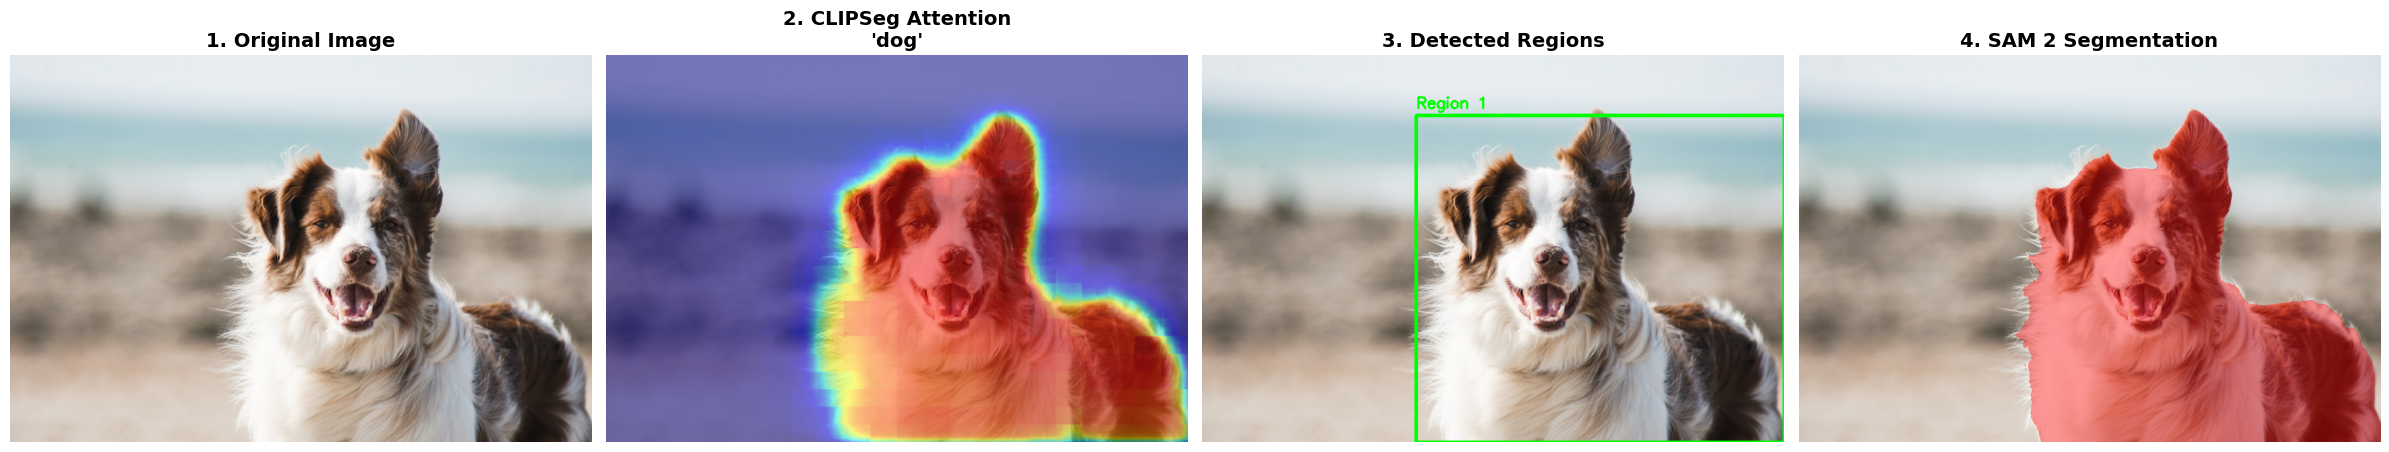

 Segmentation complete!


In [10]:

print("EXAMPLE 1: Segment a dog from sample image")
# Download sample image
image_url = "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=800"
print(f"Downloading image from Unsplash...")
image = download_image(image_url)
print(f" Image loaded: {image.shape}\n")

# Run segmentation
masks, boxes = text_driven_segmentation(image, "dog")



Testing different prompts on the dog image:


--- Trying prompt: 'dog head' ---
Prompt: 'dog head'
Image shape: (533, 800, 3)

Step 1: Converting text to regions using CLIPSeg...
Found 1 region(s)
  Region 1: [318, 84, 599, 387]

Step 2: Generating precise masks using SAM 2...
Generated 1 mask(s)
  Mask quality scores: [0.88695234]

Step 3: Visualizing results...


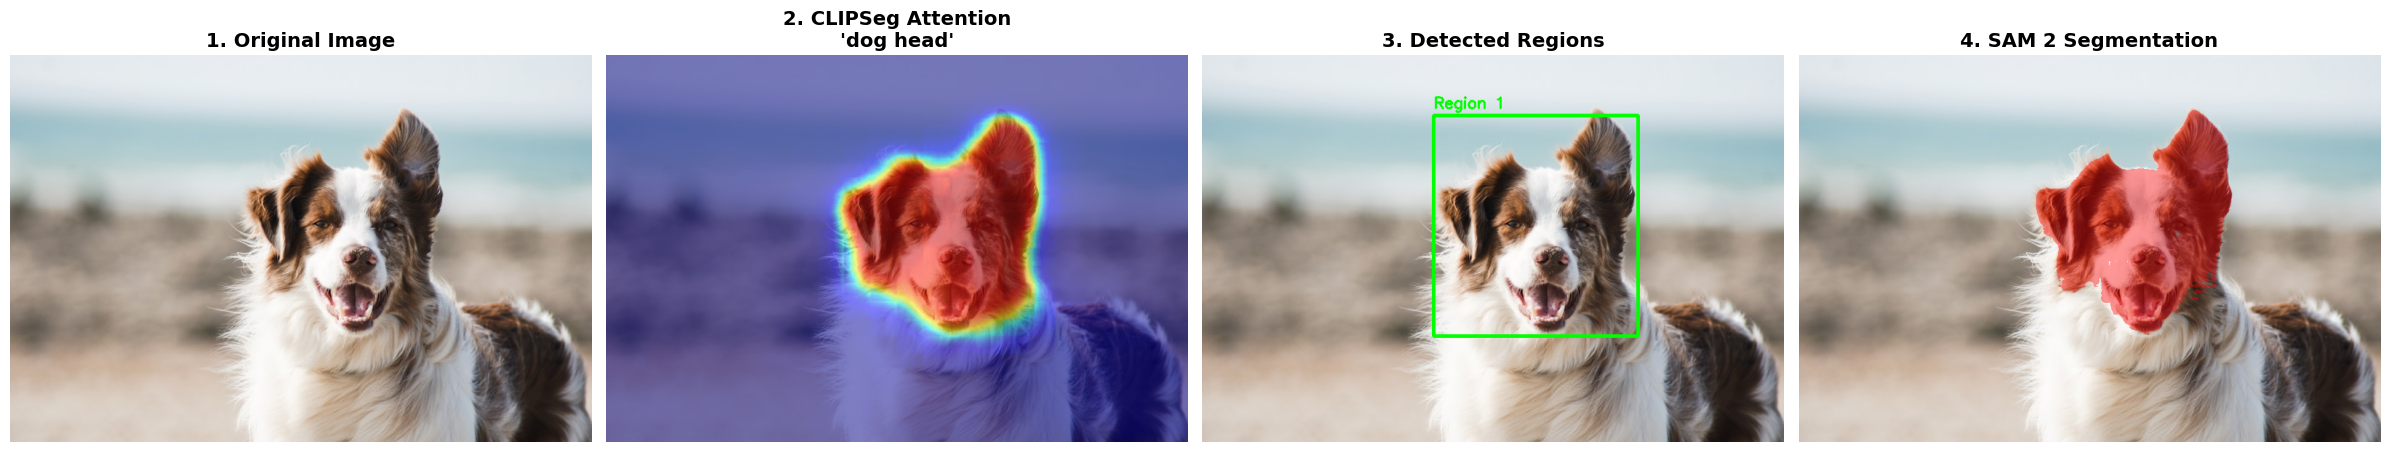

 Segmentation complete!

 Detecting multiple objects
✓ Image loaded: (450, 800, 3)

Prompt: 'person'
Image shape: (450, 800, 3)

Step 1: Converting text to regions using CLIPSeg...
Found 1 region(s)
  Region 1: [0, 210, 800, 443]

Step 2: Generating precise masks using SAM 2...
Generated 1 mask(s)
  Mask quality scores: [0.40944093]

Step 3: Visualizing results...


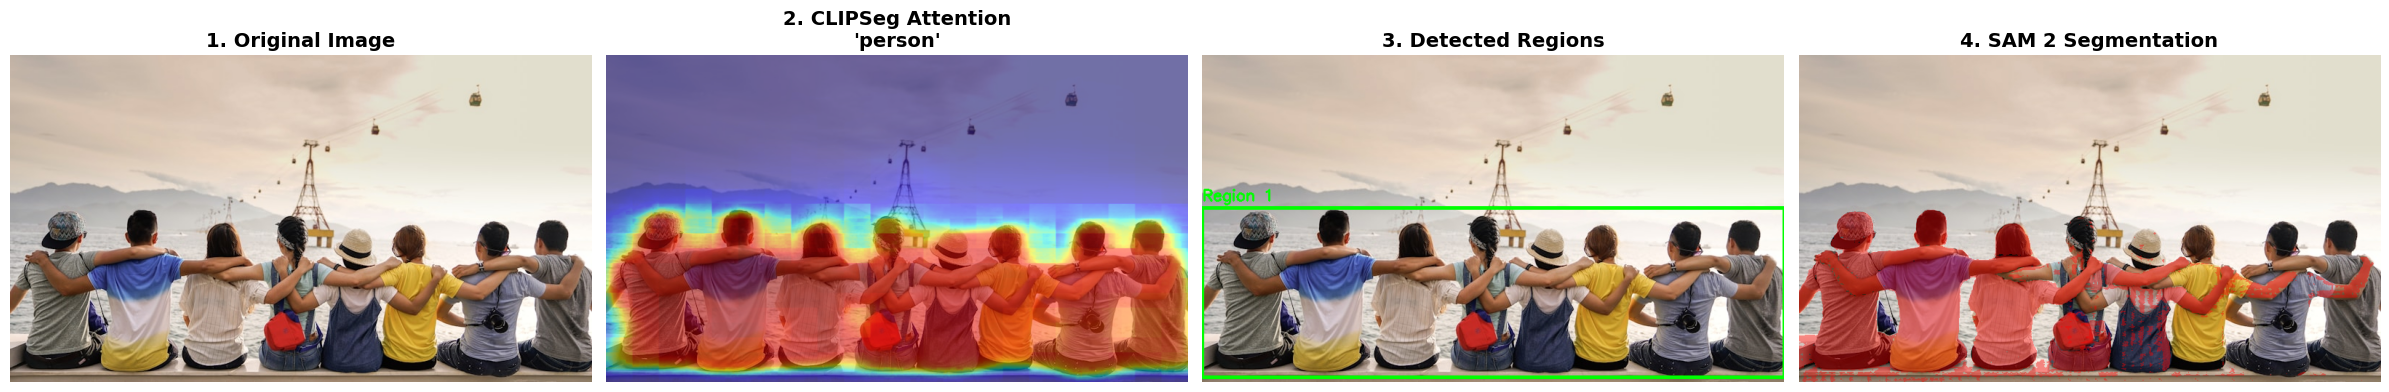

 Segmentation complete!


In [16]:


print("\nTesting different prompts on the dog image:\n")

prompts_to_try = ["dog head"]

for prompt in prompts_to_try:
    print(f"\n--- Trying prompt: '{prompt}' ---")
    masks, boxes = text_driven_segmentation(image, prompt, threshold=0.4)
    print()

print(" Detecting multiple objects")

people_url = "https://images.unsplash.com/photo-1529156069898-49953e39b3ac?w=800"
people_image = download_image(people_url)
print(f"✓ Image loaded: {people_image.shape}\n")

masks, boxes = text_driven_segmentation(people_image, "person", threshold=0.35)


 Person with Multiple Object Prompts
✓ Person image loaded: (1200, 800, 3)

Testing prompt: 'person'
Prompt: 'person'
Image shape: (1200, 800, 3)

Step 1: Converting text to regions using CLIPSeg...
Found 1 region(s)
  Region 1: [0, 30, 786, 1188]

Step 2: Generating precise masks using SAM 2...
Generated 1 mask(s)
  Mask quality scores: [0.99329644]

Step 3: Visualizing results...


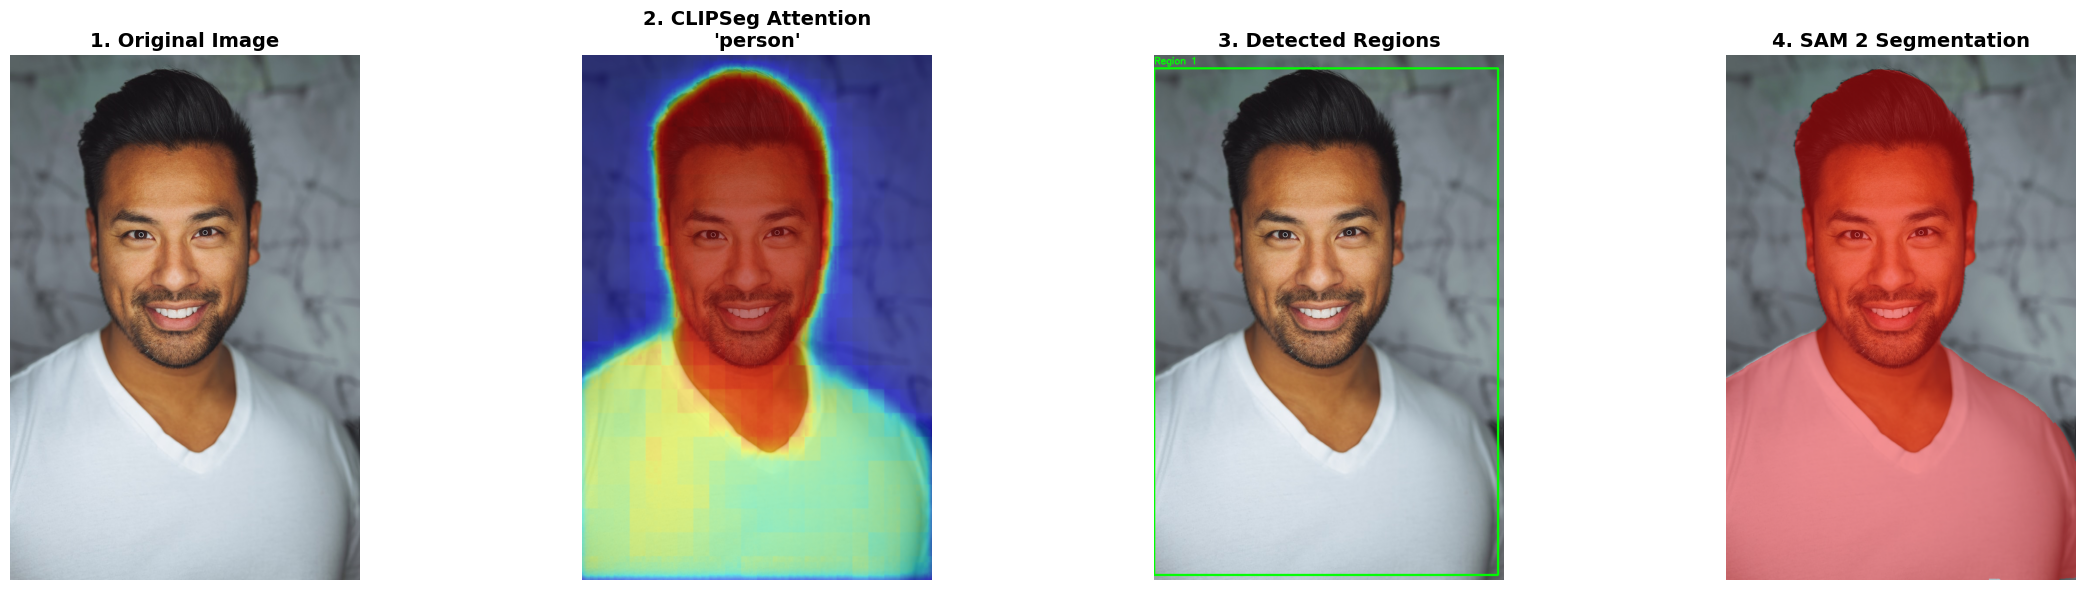

 Segmentation complete!
Testing prompt: 'face'
Prompt: 'face'
Image shape: (1200, 800, 3)

Step 1: Converting text to regions using CLIPSeg...
Found 1 region(s)
  Region 1: [172, 126, 568, 716]

Step 2: Generating precise masks using SAM 2...
Generated 1 mask(s)
  Mask quality scores: [0.8363219]

Step 3: Visualizing results...


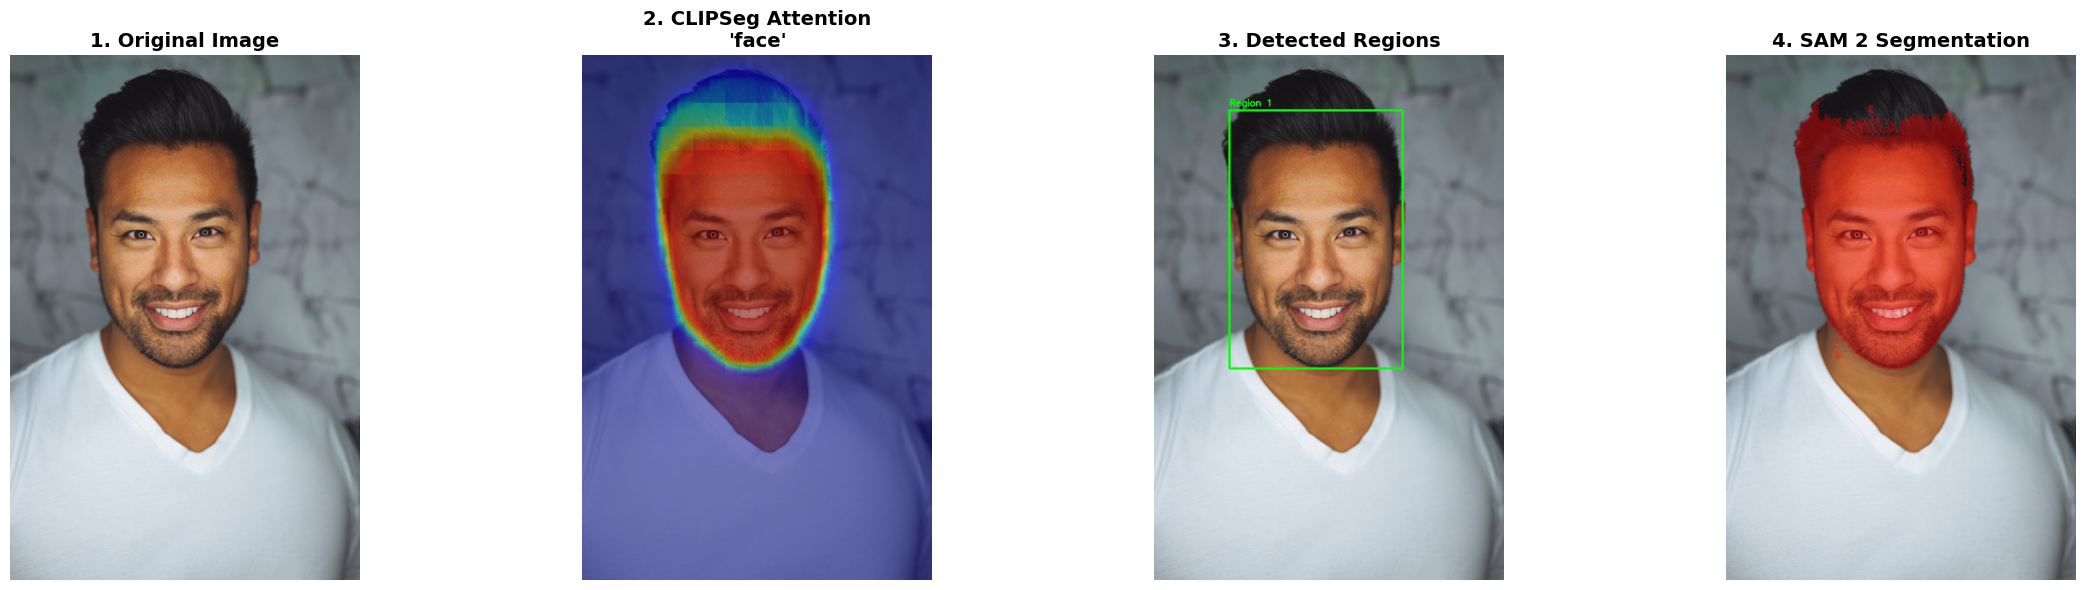

 Segmentation complete!
Testing prompt: 'shirt'
Prompt: 'shirt'
Image shape: (1200, 800, 3)

Step 1: Converting text to regions using CLIPSeg...
Found 1 region(s)
  Region 1: [0, 632, 800, 1200]

Step 2: Generating precise masks using SAM 2...
Generated 1 mask(s)
  Mask quality scores: [0.9947278]

Step 3: Visualizing results...


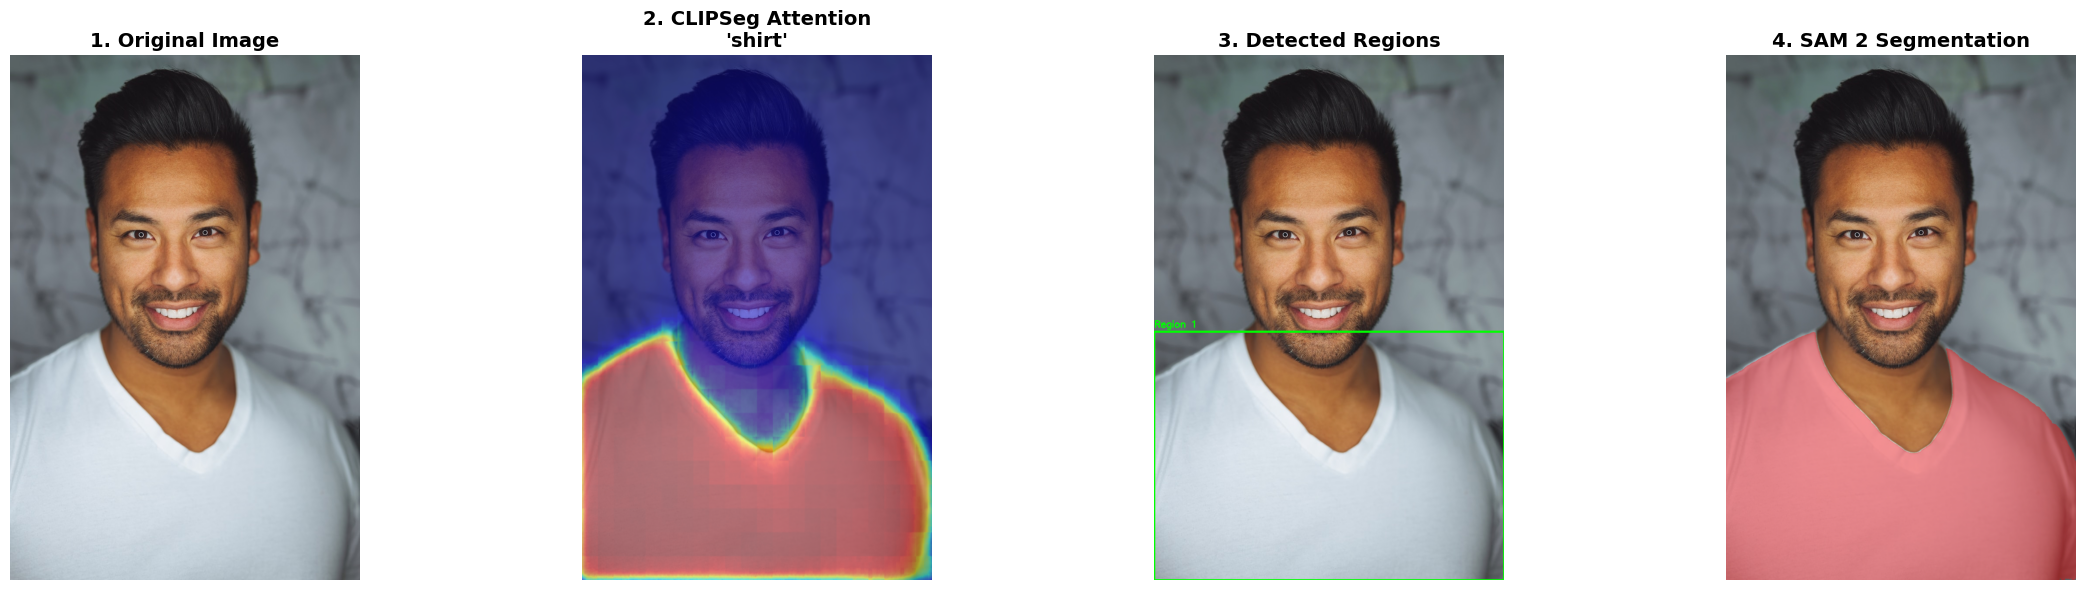

 Segmentation complete!


In [18]:

print(" Person with Multiple Object Prompts")

person_url = "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d?w=800"
person_image = download_image(person_url)
print(f"✓ Person image loaded: {person_image.shape}\n")

person_prompts = [
    "person",
    "face",
    "shirt"
]

for prompt in person_prompts:
    print(f"Testing prompt: '{prompt}'")
    masks, boxes = text_driven_segmentation(person_image, prompt, threshold=0.4)

# ============================================================================
